# Table of Contents
* [Github Repository Cloning](#chapter1)
* [Mixing the two Datasets](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
* [Feature Engineering](#chapter3)
* [Plots](#chapter4)
    * [General Statistics](#section4_1)
    * [Combined Statistics](#section4_2)
* [Feature Enginneering II](#chapter5)
    * [Categorization for Type Consistency](#section5_1)
    * [Winsorization and Drops](#section5_2)
* [K-Means Clustering](#chapter6)
* [Saving the Dataset](#chapter7)

# Github repository cloning <a class="anchor" id="chapter1"></a>
to access the datasets stored there otherwise google colab needs a new upload each time. 

In [1]:
# cloning the repository
! git init
! git clone https://github.com/simonegiancola09/h_farm_group_work.git

Initialized empty Git repository in /content/.git/
Cloning into 'h_farm_group_work'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 11), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (10/10), done.


In [2]:
# magic function to plot inline
%matplotlib inline
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# reading csvs
df_apr = pd.read_csv('/content/h_farm_group_work/April.csv')
df_feb = pd.read_csv('/content/h_farm_group_work/Feb.csv')
df_mar = pd.read_csv('/content/h_farm_group_work/Mar.csv')
df_weather = pd.read_csv('/content/h_farm_group_work/weather.csv')
# adding 30th of april as we forgot...
df_weather_30 = pd.read_excel('/content/h_farm_group_work/weatherdata30.xlsx')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# all weather data available is recovered
df_weather = pd.concat([df_weather, df_weather_30])

In [4]:
def compare_groups(df, col_label, model, cols_cluster, col_to_compare, plot_type, centers = False, perc=None):
    
    plt.figure(figsize=(12,8))
    n_clusters = df[col_label].nunique()
    for i in range(n_clusters):
        if plot_type == 'scatter':
            col1 = col_to_compare[0]
            col2 = col_to_compare[1]
            scatter = plt.scatter(df.loc[df[col_label]==i, col1], df.loc[df[col_label]==i, col2], label= i, alpha=.1)
            if centers:
                ind1 = cols_cluster.index(col1)
                ind2 = cols_cluster.index(col2)
                plt.scatter(model.cluster_centers_[i,ind1], model.cluster_centers_[i,ind2], label=f'center {i}', s=2)
        if plot_type=='bar':
            index = np.arange(df[col_to_compare].nunique())
            bar_width = .8 / n_clusters
            vals = df[df[col_label]==i][col_to_compare].value_counts(sort=False)
            if perc == 'within':
                vals = vals / df[col_to_compare].value_counts(sort=False)
            elif perc == 'across':
                    vals = vals / df[df[col_label]==i][col_to_compare].shape[0]
                    
            plt.bar(index+bar_width*i, vals, bar_width, label=i)
            if col_to_compare=='day_of_week':       
                xlabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
            elif df[col_to_compare].dtype.name=='category':
                xlabels = df[col_to_compare].value_counts(sort=False).index
            else:
                xlabels = index
            if i == n_clusters-1:
                plt.xticks(index+bar_width*i/2, xlabels)

        elif 'de' in plot_type:
            sns.kdeplot(df.loc[df[col_label]==i, col_to_compare], alpha=.1, label=i, fill=True, bw_adjust=2)
            
        elif plot_type == 'hist':
            vals = df[df[col_label]==i][col_to_compare]
            bins = 50
            plt.hist(vals, label=i, bins = bins, alpha = 0.5)

    if col_to_compare == 'Precipitation' or col_to_compare == 'Snow': #add this because otherwise cannot see anything
      plt.xlim([-0.5,2])

    plt.title(col_to_compare, size=15)
    plt.legend()
    plt.show()

In [5]:
df_weather.head()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,"Washington, DC, United States",02/01/2021 00:00:00,-0.7,-0.7,-0.7,-6.9,NaN,0.0,0.00,4.02,25.3,21.0,NaN,6.5,100.0,90.20,Overcast
1,"Washington, DC, United States",02/01/2021 01:00:00,-0.7,-0.7,-0.7,-6.6,NaN,0.0,0.17,4.18,23.0,19.0,27.7,10.5,100.0,90.05,"Snow, Overcast"
2,"Washington, DC, United States",02/01/2021 02:00:00,-0.7,-0.7,-0.7,-7.0,NaN,0.0,0.17,4.35,26.3,19.0,NaN,13.2,100.0,89.94,"Snow, Overcast"
3,"Washington, DC, United States",02/01/2021 03:00:00,-0.7,-0.7,-0.7,-6.3,NaN,0.0,0.17,4.52,21.6,9.0,25.9,11.5,100.0,90.00,"Snow, Overcast"
4,"Washington, DC, United States",02/01/2021 04:00:00,-0.7,-0.7,-0.7,-6.3,NaN,0.0,0.17,4.68,21.7,351.0,NaN,8.6,100.0,89.81,"Snow, Overcast"


In [6]:
df_weather['Date'] = pd.to_datetime(df_weather['Date time'])

In [7]:
df_weather['month'] = df_weather.Date.dt.month

In [8]:
df_weather.loc[df_weather['Conditions']=='Snow, Overcast', 'Conditions'] = 'Snow'
df_weather.loc[df_weather['Conditions']=='Rain, Overcast', 'Conditions'] = 'Rain'
df_weather.loc[df_weather['Conditions']=='Rain, Partially cloudy', 'Conditions'] = 'Rain'
df_weather.loc[df_weather['Conditions']=='Partially cloudy, Clear'] = 'Clear'

In [9]:
df_weather[df_weather.month==4].Conditions.value_counts(sort=False)/df_weather[df_weather.month==4].shape[0]

Clear               0.235784
Partially cloudy    0.212205
Overcast            0.463245
Rain                0.088766
Name: Conditions, dtype: float64

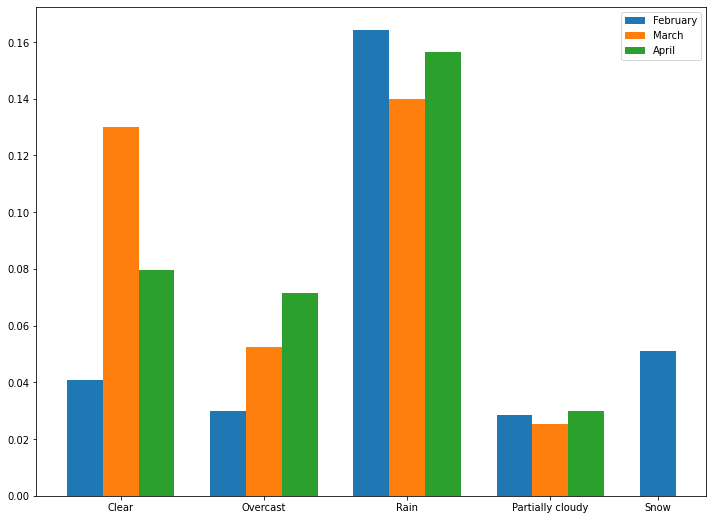

In [10]:
plt.figure(figsize=(12,9))
d = {2:'February', 3:'March', 4:'April'}
for month in np.unique(df_weather.month):

  #index = np.arange(df[col_to_compare].nunique())
  if month != 5:
    index = np.arange(df_weather[df_weather.month==month].Conditions.nunique())

    vals = df_weather[df_weather.month==month]['Conditions'].value_counts(sort=False)/df_weather[df_weather==month].shape[0]
    bar_width = 0.25
    plt.bar(index+ bar_width*(month-2), vals, label=d[month], width=bar_width)
    
    plt.xticks(np.array([0.25, 1.25, 2.25, 3.25, 4]), ['Clear', 'Overcast', 'Rain', 'Partially cloudy', 'Snow'])

plt.legend() 
plt.show()

In [11]:
np.array([0.25, 1.25, 2.25, 3.25, 4])

array([0.25, 1.25, 2.25, 3.25, 4.  ])

In [12]:
[df_weather[df_weather.month==month]['Temperature'].max() for month in [2,3,4]]

[15.2, 28.3, 29.9]

In [13]:
# merge rides dfs
df = pd.concat([df_feb, df_mar, df_apr])
# view weather dataset
df_weather.tail()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions,Date,month
20,"Washington, DC, United States",04/30/2021 20:00:00,13.2,13.2,13.2,NaN,NaN,0,0,0,27.9,299,57.4,16,48.4,47.63,Partially cloudy,2021-04-30 20:00:00,4
21,"Washington, DC, United States",04/30/2021 21:00:00,12.1,12.1,12.1,NaN,NaN,0,0,0,33.8,289,54.5,16,24.4,51.2,Clear,2021-04-30 21:00:00,4
22,"Washington, DC, United States",04/30/2021 22:00:00,12.1,12.1,12.1,NaN,NaN,0,0,0,24.5,299,47.5,16,0,49.13,Clear,2021-04-30 22:00:00,4
23,"Washington, DC, United States",04/30/2021 23:00:00,12.1,12.1,12.1,NaN,NaN,0,0,0,41.6,329,64.8,16,0,36.95,Clear,2021-04-30 23:00:00,4
24,"Washington, DC, United States",05/01/2021 00:00:00,11.1,11.1,11.1,NaN,NaN,0,0,0,35.5,319,64.2,16,0,26.05,Clear,2021-05-01 00:00:00,5


In [14]:
# view rides dataset
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0F961E4450F8544E,classic_bike,2021-02-20 14:03:25,2021-02-20 14:14:17,21st St & Pennsylvania Ave NW,31252,New York Ave & 15th St NW,31222,38.901539,-77.046564,38.899032,-77.033354,casual
1,DFD528B4F2B3CA6A,classic_bike,2021-02-15 09:54:23,2021-02-15 11:21:02,Hains Point/Buckeye & Ohio Dr SW,31273,Hains Point/Buckeye & Ohio Dr SW,31273,38.878433,-77.030230,38.878433,-77.030230,member
2,2398431BB0EB78BE,classic_bike,2021-02-15 09:53:12,2021-02-15 09:53:34,Hains Point/Buckeye & Ohio Dr SW,31273,Hains Point/Buckeye & Ohio Dr SW,31273,38.878433,-77.030230,38.878433,-77.030230,member
3,6E32C58697957443,classic_bike,2021-02-24 14:50:17,2021-02-24 15:29:01,Hains Point/Buckeye & Ohio Dr SW,31273,Hains Point/Buckeye & Ohio Dr SW,31273,38.878433,-77.030230,38.878433,-77.030230,member
4,2DCACE8B26B0A50A,classic_bike,2021-02-05 16:39:10,2021-02-05 16:39:13,Hains Point/Buckeye & Ohio Dr SW,31273,Hains Point/Buckeye & Ohio Dr SW,31273,38.878433,-77.030230,38.878433,-77.030230,member


In [15]:
# trivial merge check
assert len(df) == len(df_apr) + len(df_mar) + len(df_feb)

In [16]:
# reset index to avoid confusion. Index is useless per se
df.reset_index(inplace = True)

In [17]:
# an example of an NaN row
# remember to account for this, uniform distribution across stations is unlikely. 
# each ride takes some time and we might end up distributing stations far apart
# with short rides
df.loc[51400]

index                               51400
ride_id                  65E9926383577E58
rideable_type               electric_bike
started_at            2021-02-14 10:04:40
ended_at              2021-02-14 10:09:55
start_station_name          Thomas Circle
start_station_id                    31241
end_station_name                      NaN
end_station_id                        NaN
start_lat                         38.9059
start_lng                        -77.0326
end_lat                              38.9
end_lng                            -77.02
member_casual                      member
Name: 51400, dtype: object

In [18]:
# rate of NaNs for the two datasets
# just to understand the gravity of missing values wrt the whole
print('Bike rides NaN rate:', df.isnull().values.sum() / (df.shape[0] * df.shape[1]), '\n')
print('Weather samples NaN rate', df_weather.isnull().values.sum() / (df_weather.shape[0] * df_weather.shape[1]), '\n')


Bike rides NaN rate: 0.02860347246542467 

Weather samples NaN rate 0.11701105829618501 



In [19]:
# an example of wor with missing values in df_weather
df_weather.iloc[0]

Name                   Washington, DC, United States
Date time                        02/01/2021 00:00:00
Maximum Temperature                             -0.7
Minimum Temperature                             -0.7
Temperature                                     -0.7
Wind Chill                                      -6.9
Heat Index                                       NaN
Precipitation                                      0
Snow                                               0
Snow Depth                                      4.02
Wind Speed                                      25.3
Wind Direction                                    21
Wind Gust                                        NaN
Visibility                                       6.5
Cloud Cover                                      100
Relative Humidity                               90.2
Conditions                                  Overcast
Date                             2021-02-01 00:00:00
month                                         

In [20]:
# further: analyze which columns have a high rate of missing values wrt the total
# and choose whether dropping is better than keeping a useless info such as
# e.g. Wind Gust
def count_perc_missing(df : pd.DataFrame) -> pd.DataFrame:
    """
    Returns dictionary with percentages of missing values for each column
    with respect to the total number of missing values
    :df: Pandas dataframe to examine
    :return: Dataframe with percentages, first is overall, second is wrt the column
    """
    cols = df.columns
    # we do not have to loop over index as it will not be an NaN
    if cols[0] == 'index':
      cols = cols[1:]
    tot = df.isnull().values.sum()
    num_nan_overall = []
    num_nan_overcol = []
    for col in cols:
      num_nan_overall.append(df[col].isnull().values.sum())
      num_nan_overcol.append(df[col].isnull().values.sum() / len(df[col]))
    assert len(cols) == len(num_nan_overall)
    # return {cols[i]:(num_nan_overall[i] / tot, num_nan_overcol[i]) for i in range(len(cols))}
    df = pd.DataFrame(columns = ['overall', 'over_column'])
    df['overall'] = num_nan_overall / tot
    df['over_column'] = num_nan_overcol
    df['feature'] = cols
    df.set_index('feature', inplace = True)
    return df

In [21]:
# we calculate the percentage of missing values for each column in the datasets
perc_nan_weather = count_perc_missing(df_weather)
perc_nan_rides = count_perc_missing(df) 

In [22]:
# in the weather dataset we might delete the two columns as they are almost useless
perc_nan_weather

,overall,over_column
feature,,
Name,0.000000,0.000000
Date time,0.000000,0.000000
Maximum Temperature,0.000000,0.000000
Minimum Temperature,0.000000,0.000000
Temperature,0.000000,0.000000
Wind Chill,0.225637,0.501638
Heat Index,0.444328,0.987833
Precipitation,0.000000,0.000000
Snow,0.000000,0.000000


In [23]:
# here it is more complicated, we have to reason more
perc_nan_rides

,overall,over_column
feature,,
ride_id,0.000000,0.000000
rideable_type,0.000000,0.000000
started_at,0.000000,0.000000
ended_at,0.000000,0.000000
start_station_name,0.235312,0.094231
start_station_id,0.235312,0.094231
end_station_name,0.260615,0.104363
end_station_id,0.260615,0.104363
start_lat,0.000011,0.000004


In [24]:
# we have to change the format of the date strings into a datatime format to
# make operations, it can be notices by this simple cell
print('Dates in rides dataset type', type(df['started_at'][0]))
print('Dates in weather dataset type', type(df_weather['Date time'][0]))

Dates in rides dataset type <class 'str'>
Dates in weather dataset type <class 'pandas.core.series.Series'>


In [25]:
# to do so we can use the pd.to_datetime method and overwrite the columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df_weather['Date time'] = pd.to_datetime(df_weather['Date time'])

In [26]:
# to understand how to merge the datasets we could observe the average and maximum length
# of the rides. An easy way would be using the weather data from the starting condition only
# measurements are done hourly so if the average and the maximum ride are not far from 
# one hour an easier merge could be done
dist = df['ended_at'] - df['started_at']
print('max is:', np.max(dist), '\n', 'average is:', np.sum(dist) / len(dist))

max is: 26 days 20:34:45 
 average is: 0 days 00:27:15.024452499


In [27]:
def quantiles_and_iqr(col : pd.Series) -> tuple:
  """
  Function to return all canonical quantiles, the iqr and the bounds for outliers
  :col: Pandas series to examinate
  :return: tuple with (first_quantile, median, third_quantile, IQR, lower_buond, upper_bound)
  """
  q1 = col.quantile(0.25)
  med = col.quantile(0.5)
  q3 = col.quantile(0.75)
  iqr = q3 - q1
  lower_bound = (q1 - 1.5 * iqr)
  upper_bound = (q3 + 1.5 * iqr)
  return q1, med, q3, iqr, lower_bound, upper_bound


In [28]:
distance_rides_qts = quantiles_and_iqr(dist)

In [29]:
distance_rides_qts
# from this we can see that any ride longer than one hour is considered as an outlier
# in general, shorter rides are preferred, ideally for short distance commutes

(Timedelta('0 days 00:07:18'),
 Timedelta('0 days 00:13:08'),
 Timedelta('0 days 00:23:35'),
 Timedelta('0 days 00:16:17'),
 Timedelta('-1 days +23:42:52.500000'),
 Timedelta('0 days 00:48:00.500000'))

In [30]:
# check for outliers percentage
dist[dist>distance_rides_qts[5]*2].size/dist.size

0.028167319463811118

# Mixing the two datasets <a class="anchor" id="chapter2"></a>
The approach is matching the hour for each measurement

In [31]:
# basic imports
import datetime
import seaborn as sns

In [32]:
df_weather['Date time']

0    2021-02-01 00:00:00
1    2021-02-01 01:00:00
2    2021-02-01 02:00:00
3    2021-02-01 03:00:00
4    2021-02-01 04:00:00
             ...        
20   2021-04-30 20:00:00
21   2021-04-30 21:00:00
22   2021-04-30 22:00:00
23   2021-04-30 23:00:00
24   2021-05-01 00:00:00
Name: Date time, Length: 2137, dtype: datetime64[ns]

In [33]:
df['started_at']

0        2021-02-20 14:03:25
1        2021-02-15 09:54:23
2        2021-02-15 09:53:12
3        2021-02-24 14:50:17
4        2021-02-05 16:39:10
                 ...        
465428   2021-04-17 13:07:49
465429   2021-04-03 15:35:32
465430   2021-04-27 17:20:09
465431   2021-04-30 12:16:48
465432   2021-04-16 16:22:30
Name: started_at, Length: 465433, dtype: datetime64[ns]

In [34]:
def mix_datasets(df_rides : pd.DataFrame, df_weather : pd.DataFrame) -> pd.DataFrame:
  """
  The idea is to find for each ride the starting time and attaching to it the
  correspondent weather information
  :df_rides: Dataframe of the rides to loop on
  :df_weather: Dataframe of the weather data to insert
  :return: merged Dataframe
  """
  # we have to shorten the date for the first dataset as they are not comparable
  truncated_rides_col = df_rides['started_at'].values.astype('<M8[h]')
  # we create a copy just to avoid messing up
  df = df_rides.copy(deep = True)
  # append the column for comparison
  df['Time_to_compare'] = truncated_rides_col
  # merge with a left join to avoid missing rides, hopefully all times will
  # be available on the weather data
  new_df = pd.merge(df, df_weather, left_on = 'Time_to_compare', right_on = 'Date time', how = 'left')
  return new_df


In [35]:
df['started_at'].values.astype('<M8[h]')[0]
df_weather['Date time'].values.astype('<M8[h]')[0]

numpy.datetime64('2021-02-01T00','h')

In [36]:
df_weather['Date time']

0    2021-02-01 00:00:00
1    2021-02-01 01:00:00
2    2021-02-01 02:00:00
3    2021-02-01 03:00:00
4    2021-02-01 04:00:00
             ...        
20   2021-04-30 20:00:00
21   2021-04-30 21:00:00
22   2021-04-30 22:00:00
23   2021-04-30 23:00:00
24   2021-05-01 00:00:00
Name: Date time, Length: 2137, dtype: datetime64[ns]

In [37]:
new_df = mix_datasets(df, df_weather)

In [38]:
new_df.shape

(465503, 34)

In [39]:
new_df.isna().sum()

index                       0
ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name      43880
start_station_id        43880
end_station_name        48594
end_station_id          48594
start_lat                   2
start_lng                   2
end_lat                   758
end_lng                   758
member_casual               0
Time_to_compare             0
Name                        0
Date time                   0
Maximum Temperature         0
Minimum Temperature         0
Temperature                 0
Wind Chill             334348
Heat Index             450517
Precipitation               0
Snow                        0
Snow Depth                  0
Wind Speed                  0
Wind Direction            334
Wind Gust              295740
Visibility                  0
Cloud Cover                 0
Relative Humidity           0
Conditions                  0
Date                        0
month     

In [40]:
# lens should be equal
len(new_df), len(df)

(465503, 465433)

In [41]:
# now we can do some operations on the dataset like removing rows and 
# tidying up the information stored
def tidy_data2(df : pd.DataFrame, to_drop : list, keep_stations = True) -> pd.DataFrame:
    '''
    Newer function that does all that is needed. Also rides for which the time
    distance is negative are dropped.
      :df: target dataframe
      :to_drop: names of the columns to drop
      :keep_stations: boolean value. If True the stations are kept.
      :return: adjusted dataframe
    '''
    # useless as it is always Washington
    final_df = df.drop(['Name'], axis = 1)
    # time to compare is repeated at 'Date time'
    # for the sake of clarity we keep the original index of each dataset 
    # but we could just delete it
    final_df.rename({'index' : 'original_index'})
    if not keep_stations:
        # another solution would be attempting to estimate the closest station
        # but does a close station influence someone's decision to rent? Not really, 
        # a customer rents a bike regardless of a close station, and most likely
        # drops it off regardlessly again. We could explore places where new stations
        # should be placed. 
        final_df.drop(['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name'], inplace = True, axis = 1)
    # values are almost not informative as they are not present in most of the sample
    final_df.drop(to_drop, inplace = True, axis = 1)
    #drop columns where starting time happened at a alater time than ending one
    index_drop = df[df['ended_at'] < df['started_at']].index
    final_df.drop(index_drop, inplace = True)
    # a small number of samples has missing lat and long information, we could simply drop it
    # as we are already working with high N
    # another small sample falls on the 30th of April and we do not have data on this
    # my mistake, we could retrieve it
    final_df.dropna(axis = 0, inplace = True)
    # doing all of this we should be certain that there are no NaNs in the dataset
    return final_df



In [42]:
to_drop = ['ride_id', 'Time_to_compare', 'Date time', 'Wind Chill', 'Heat Index', 'Wind Gust']
final_df = tidy_data2(new_df, to_drop, False)

In [43]:
# NA assertion
assert final_df.isnull().values.sum() == 0

In [44]:
# returns nan on overall number as it is a division by zero
count_perc_missing(final_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


,overall,over_column
feature,,
rideable_type,NaN,0.0
started_at,NaN,0.0
ended_at,NaN,0.0
start_lat,NaN,0.0
start_lng,NaN,0.0
end_lat,NaN,0.0
end_lng,NaN,0.0
member_casual,NaN,0.0
Maximum Temperature,NaN,0.0


In [45]:
final_df.shape

(464324, 23)

# Feature Engineering <a class="anchor" id="chapter3"></a>
Add variables to final_df

In [46]:
import datetime
# good to know, some dists are actually negative in time which is impossible
np.sum(dist < datetime.timedelta(0))

90

In [47]:
# check average usage by types of conditions and percentage of use by members 

for el in df_weather.Conditions.unique():
    rides = final_df[final_df.Conditions==el]
    days = df_weather[df_weather.Conditions==el]
    perc_member = np.sum(rides['member_casual']=='member')
    print( f"With {el}, mean rides count is: {rides.shape[0]/days.shape[0]:0.2f} in {days.shape[0]} hours.", \
         f"Perc members: {perc_member/rides.shape[0]}")

With Overcast, mean rides count is: 222.42 in 984 hours. Perc members: 0.5907666157965439
With Snow, mean rides count is: 41.51 in 61 hours. Perc members: 0.7606635071090048
With Rain, mean rides count is: 77.44 in 227 hours. Perc members: 0.6925133689839572
With Partially cloudy, mean rides count is: 300.20 in 329 hours. Perc members: 0.552756543309877
With Clear, mean rides count is: 236.18 in 536 hours. Perc members: 0.5561690799503914


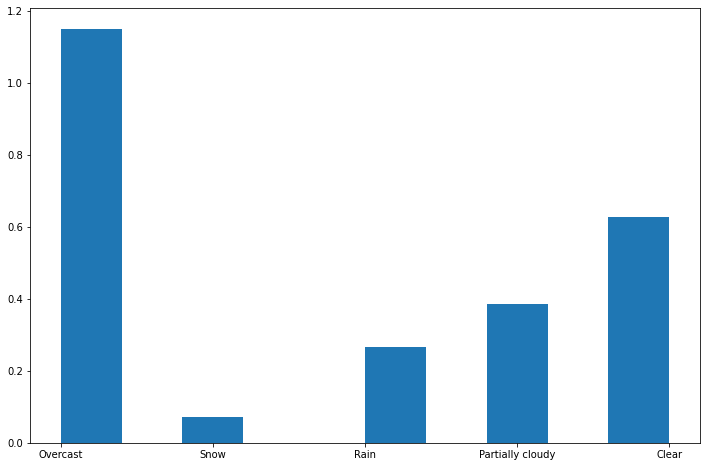

Overcast present 46.045858680393074%
Snow present 2.8544688816097334%
Rain present 10.622367805334582%
Partially cloudy present 15.395414131960692%
Clear present 25.08189050070192%


In [48]:
#plot of the conditions observed in the time period studied

plt.figure(figsize=(12,8))
plt.hist(df_weather['Conditions'], density=True)
plt.show()
for cond in df_weather.Conditions.unique():
    perc = np.sum(df_weather['Conditions']==cond)/df_weather.shape[0]
    print(f"{cond} present {perc*100}%")

In [49]:
#function to add distance between starting and ending stations

from geopy import distance

def add_distance(df):
    '''
    Adds distance to a dataframe containing latitude and longitude features.
    '''
    f = distance.distance
    df['distance'] = df[['start_lat', 'start_lng', 'end_lat', 'end_lng']].apply(lambda row: 
                                             f((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])).km, axis=1)


In [50]:
add_distance(final_df)

In [51]:
final_df = final_df.sort_values(by=['started_at'], ignore_index=True)

In [52]:
final_df.head()

,index,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions,Date,month,distance
0,66993,electric_bike,2021-02-01 00:01:52,2021-02-01 00:07:59,38.930000,-77.040000,38.920000,-77.020000,casual,-0.7,-0.7,-0.7,0,0,4.02,25.3,21,6.5,100,90.2,Overcast,2021-02-01 00:00:00,2,2.059223
1,36222,classic_bike,2021-02-01 00:01:57,2021-02-01 00:13:49,38.934881,-77.072755,38.947156,-77.065115,casual,-0.7,-0.7,-0.7,0,0,4.02,25.3,21,6.5,100,90.2,Overcast,2021-02-01 00:00:00,2,1.515155
2,1044,electric_bike,2021-02-01 00:04:42,2021-02-01 00:17:35,38.897266,-77.070785,38.905247,-77.050538,member,-0.7,-0.7,-0.7,0,0,4.02,25.3,21,6.5,100,90.2,Overcast,2021-02-01 00:00:00,2,1.967222
3,5330,electric_bike,2021-02-01 00:16:50,2021-02-01 00:29:14,38.908557,-77.032525,38.883513,-77.021682,casual,-0.7,-0.7,-0.7,0,0,4.02,25.3,21,6.5,100,90.2,Overcast,2021-02-01 00:00:00,2,2.935022
4,57248,electric_bike,2021-02-01 00:21:57,2021-02-01 00:37:54,38.920000,-77.070000,38.900000,-77.050000,casual,-0.7,-0.7,-0.7,0,0,4.02,25.3,21,6.5,100,90.2,Overcast,2021-02-01 00:00:00,2,2.817602


In [53]:
final_df['Conditions'].unique()

array(['Overcast', 'Snow', 'Rain', 'Partially cloudy', 'Clear'],
      dtype=object)

In [54]:
#aggregate similar conditions to have less categories
final_df.loc[final_df['Conditions']=='Snow, Overcast', 'Conditions'] = 'Snow'
final_df.loc[final_df['Conditions']=='Rain, Overcast', 'Conditions'] = 'Rain'
final_df.loc[final_df['Conditions']=='Rain, Partially cloudy', 'Conditions'] = 'Rain'
final_df.loc[final_df['Conditions']=='Partially cloudy, Clear'] = 'Clear'



In [55]:
#separating time in its components (month, month day, hour, minute)
# add time used for each ride and converting it in seconds
# transforming categorical variable into category types to encode them
final_df['started_at'] = pd.to_datetime(final_df['started_at'], format = '%Y-%m-%d %H:%M:%S')
final_df['ended_at'] = pd.to_datetime(final_df['ended_at'], format = '%Y-%m-%d %H:%M:%S')
final_df['Time_spent'] = final_df['ended_at'] - final_df['started_at']



final_df['month_day'] = final_df['started_at'].dt.day
final_df['month'] = final_df['started_at'].dt.month
final_df['hour_started'] = final_df['started_at'].dt.hour
final_df['minute_started'] = final_df['started_at'].dt.minute
final_df['hour_ended'] = final_df['ended_at'].dt.hour
final_df['minute_ended'] = final_df['ended_at'].dt.minute
final_df['day_of_week'] = final_df['started_at'].dt.dayofweek
final_df['rideable_type'] = final_df['rideable_type'].astype('category')
final_df['Conditions'] = final_df['Conditions'].astype('category')
final_df['member_casual'] = final_df['member_casual'].astype('category')
# this is wrong, corrected below
# final_df['Time_spent'] = pd.to_timedelta(final_df['Time_spent']).dt.seconds
final_df['Time_spent'] = final_df['Time_spent'].dt.total_seconds()

In [56]:
# simple label encoding

final_df['rideable_type_dummy'] = final_df['rideable_type'].cat.codes
final_df['Conditions_dummy'] = final_df['Conditions'].cat.codes
final_df['member_casual_dummy'] = final_df['member_casual'].cat.codes

In [57]:
#mapping from categories to their encoded values

dict( enumerate(final_df['Conditions'].cat.categories ) )


{0: 'Clear', 1: 'Overcast', 2: 'Partially cloudy', 3: 'Rain', 4: 'Snow'}

In [58]:
dict( enumerate(final_df['rideable_type'].cat.categories ) )


{0: 'classic_bike', 1: 'docked_bike', 2: 'electric_bike'}

In [59]:
dict( enumerate(final_df['rideable_type'].cat.categories ) )


{0: 'classic_bike', 1: 'docked_bike', 2: 'electric_bike'}

In [60]:
#For clustering purposes, it is more accurate to use a polar function of time to take into account time jumps between 23 and 00
#
def time_to_polar(hour, minute):
    angle = np.pi * 2 * (hour * 60 + minute) / (24 * 60)
    return np.array([np.cos(angle), np.sin(angle)])

final_df['hour_started_polar'] = time_to_polar(final_df['hour_started'], final_df['minute_started'])[0]
final_df['minute_started_polar'] = time_to_polar(final_df['hour_started'], final_df['minute_started'])[1]

final_df['hour_ended_polar'] = time_to_polar(final_df['hour_ended'], final_df['minute_ended'])[0]
final_df['minute_ended_polar'] = time_to_polar(final_df['hour_ended'], final_df['minute_ended'])[1]

In [61]:
final_df.dtypes

index                           object
rideable_type                 category
started_at              datetime64[ns]
ended_at                datetime64[ns]
start_lat                       object
start_lng                       object
end_lat                         object
end_lng                         object
member_casual                 category
Maximum Temperature             object
Minimum Temperature             object
Temperature                     object
Precipitation                   object
Snow                            object
Snow Depth                      object
Wind Speed                      object
Wind Direction                  object
Visibility                      object
Cloud Cover                     object
Relative Humidity               object
Conditions                    category
Date                            object
month                            int64
distance                        object
Time_spent                     float64
month_day                

In [62]:
# a strange maximum is found, here is the relative data
df.iloc[[np.argmax(dist)]]

,index,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
291370,42700,C93358DA8EC8FC55,docked_bike,2021-04-04 15:14:13,2021-05-01 11:48:58,Falls Church City Hall / Park Ave & Little Fal...,32608,Falls Church City Hall / Park Ave & Little Fal...,32608,38.885434,-77.173605,38.885434,-77.173605,casual


In [63]:
# checking if the problem persists
assert (final_df['Time_spent'] < 0).sum() == 0

# Plots <a class="anchor" id="chapter4"></a>

## General Statistics <a class="anchor" id="section4_1"></a>

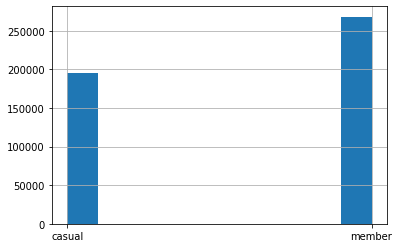

In [64]:
final_df['member_casual'].hist()

In [65]:
# percentage of rides
print('The percentage of total rides is \n',(final_df['member_casual'].value_counts() / len(final_df))[0].round(2), 'for members\n',
      (1 - (final_df['member_casual'].value_counts() / len(final_df))[0]).round(2), 'for casuals')

The percentage of total rides is 
 0.58 for members
 0.42 for casuals


In [66]:
final_df.columns

Index(['index', 'rideable_type', 'started_at', 'ended_at', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

In [67]:
# mean duration of rides
mean_time = dist.mean().components
print('An average ride lasts', mean_time[2], 'minutes and', mean_time[3], 'seconds')

An average ride lasts 27 minutes and 15 seconds


<BarContainer object of 3 artists>

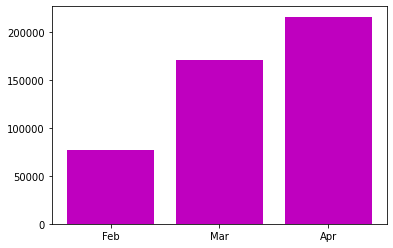

In [68]:
# total number of rides per month
rides_by_month = final_df['month'].value_counts()
dict_rides = {'Feb' : rides_by_month[2], 'Mar' : rides_by_month[3], 'Apr' : rides_by_month[4]}
plt.bar(list(dict_rides.keys()), dict_rides.values(), color = 'm')

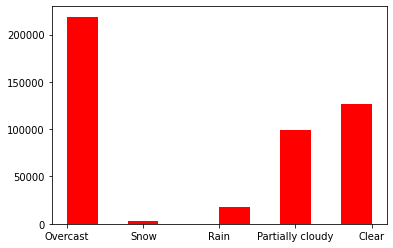

In [69]:
final_df['Conditions'].hist(color = 'r', grid = False)

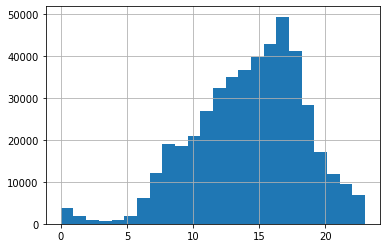

In [70]:
# peak hours are identified by the distribution of hour_started and hour_ended
final_df['hour_started'].hist(bins = 24)
# hour ended is similar
# peak hour identified between 16:00 and 17:00

In [71]:
# conditions by month histogram
grouped_by_month_df = final_df.groupby('month')
feb = grouped_by_month_df['Conditions'].value_counts()[2]
mar = grouped_by_month_df['Conditions'].value_counts()[3]
apr = grouped_by_month_df['Conditions'].value_counts()[4]
d_feb = {v : feb[v] for v in feb.index}
d_mar = {v : mar[v] for v in mar.index}
d_apr = {v : mar[v] for v in apr.index}

Text(0.5, 1.0, 'April')

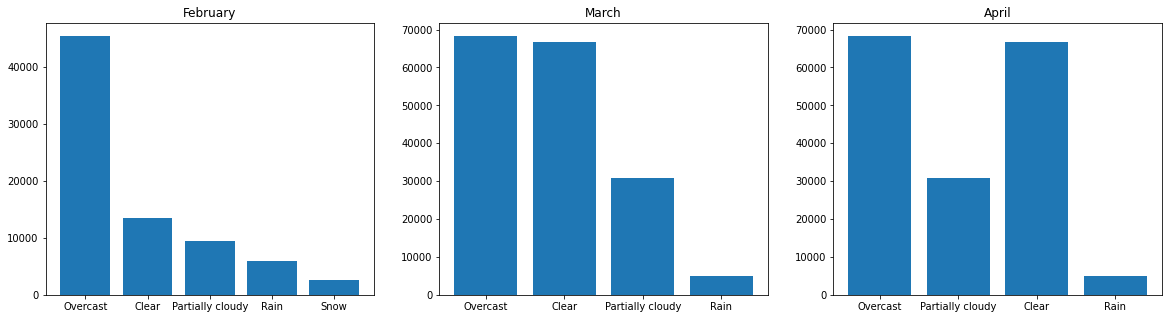

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))

ax1.bar(list(d_feb.keys()), d_feb.values())
ax1.set_title('February')
ax2.bar(list(d_mar.keys()), d_mar.values())
ax2.set_title('March')
ax3.bar(list(d_apr.keys()), d_apr.values())
ax3.set_title('April')

## Combined Statistics <a class="anchor" id="section4_2"></a>

In [73]:
# we try to print the 20 highest values just to understand the instance of this 
# phenomenon of long rides
longest = np.argsort(-dist)
for i in range(20):
  print(df.iloc[longest[i]]['index'], dist.iloc[longest[i]])
# this will be a problem to deal with

42700 26 days 20:34:45
97988 24 days 21:16:26
77080 24 days 13:45:07
101087 23 days 16:25:26
142007 23 days 03:37:20
128579 20 days 13:08:54
22085 17 days 23:50:01
124394 17 days 21:28:27
22176 16 days 19:04:00
80255 16 days 15:16:14
149263 16 days 14:17:54
64045 15 days 05:22:48
85195 15 days 01:16:24
156254 14 days 18:47:49
33441 14 days 08:23:00
199120 13 days 17:57:43
97770 13 days 14:10:35
3018 12 days 23:20:19
3148 11 days 14:42:51
30594 10 days 10:46:53


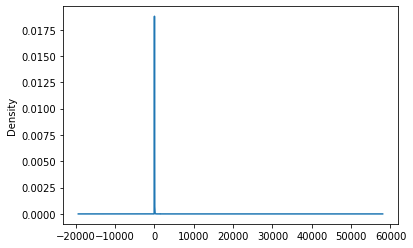

In [74]:
# plotting the distribution of hours spent
dist_min = dist / np.timedelta64(1, 'm')
dist_min.plot(kind = 'density')
# this is good, if we plot as a density then most are concentrated around few minutes somehow
# nevertheless, the high number of outliers will have to be dealt with when
# defining a distance for the clusters. Most likely those that ride for such a long time
# do not end up using it 24/7 and so a maximum ride time could be used as a placeholder

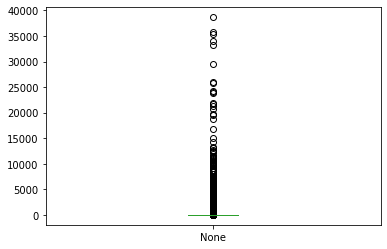

In [75]:
dist_min.plot.box()
# there is a huge number of outliers

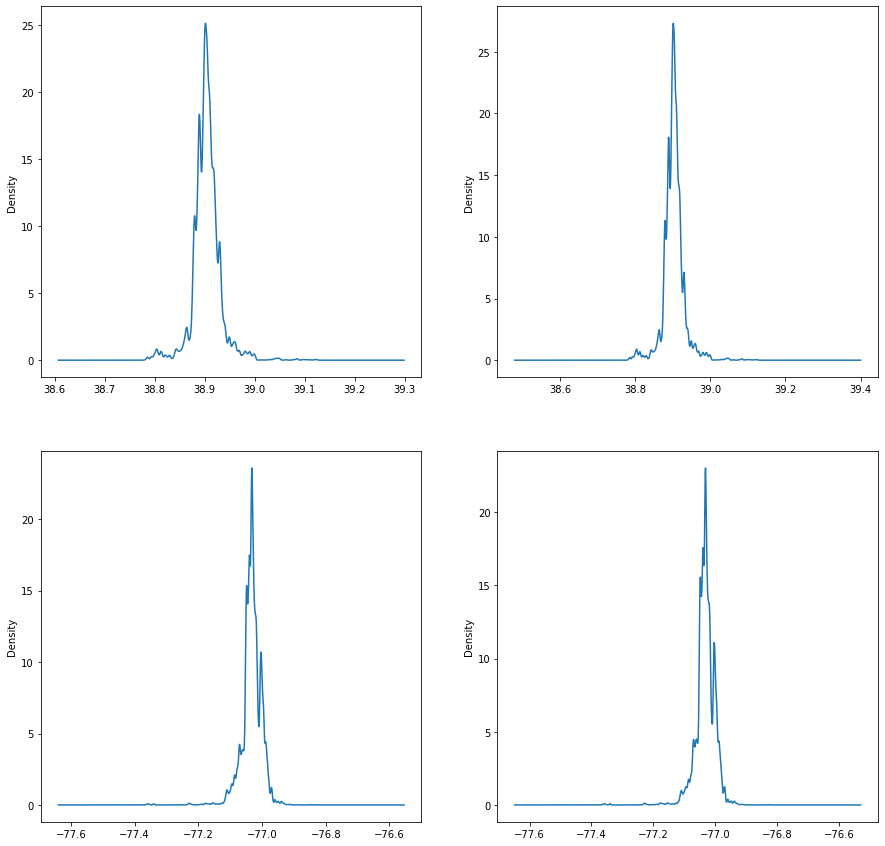

In [76]:
# we might also want to look at the distribution of the latitude and longitude
# to check if they could replace stations which are missing in around 9% of the sample
# if there is enough variability they could explain the location change alone
fig, axs = plt.subplots(2, 2, figsize = (15, 15))

df['start_lat'].plot(ax = axs[0, 0], kind = 'density')
df['end_lat'].plot(ax = axs[0, 1], kind = 'density')
df['start_lng'].plot(ax = axs[1, 0], kind = 'density')
df['end_lng'].plot(ax = axs[1, 1], kind = 'density')

In [77]:
from scipy.stats import gaussian_kde
from mpl_toolkits import mplot3d
# slow but very informative
# it is better to view the positional data as a bivariate distribution as lat
# is always paired with lng, this way we can notice that the behavior is 
# good, with an evident concentration around the center
def lat_long_density_plot(df : pd.DataFrame, positions = ['start', 'end'] ) -> None:
  """
  Plot the bivariate density distribution estimation of the starting position
  and ending position. A grid is sampled to avoid showing too many datapoints
  df: Pandas dataframe with the coordinates
  return: None
  """
  fig = plt.figure(figsize = (30, 15))
  for s in positions:
    lat, lng = df[s + '_lat'].dropna().to_numpy(), df[s + '_lng'].dropna().to_numpy()
    lat_lng = np.vstack([lat, lng])
    density = gaussian_kde(lat_lng)
    lat_i, lng_i = np.mgrid[lat.min(): lat.max():100j, lng.min(): lng.max():100j]
    di = density(np.vstack([lat_i.flatten(), lng_i.flatten()]))
    # from this we can notice that 
    di.reshape(lng_i.shape)
    if s == positions[0]:
      ax1 = fig.add_subplot(121, projection = '3d')
      ax1.scatter(lat_i, lng_i, di)
      ax1.title.set_text('Starting Positions')
    else:
      ax2 = fig.add_subplot(122, projection = '3d')
      ax2.scatter(lat_i, lng_i, di)
      ax2.title.set_text('Ending Positions')
  fig.show()



In [78]:
# from these plots we can notice that the distribution is pretty much uniform
# there is a slight concentration but it looks like there is enough variability
# this could allow us to drop the stations which are often missing

# very slow, so commented out
# lat_long_density_plot(df)

In [79]:
#naive comparison between means of variables with respect to member_casual variable, 
# might reveal in a glance the variables we should look at if interested in differences between member and casuals


cols_difference = {}
for col in final_df.dtypes[(final_df.dtypes=='int64') | (final_df.dtypes=='float64')].index:
    diff = final_df[final_df['member_casual']=='member'][col].mean() - final_df[final_df['member_casual']=='casual'][col].mean()
    cols_difference[col] = diff
cols_difference

{'Time_spent': -1677.2919635977773,
 'day_of_week': -0.4761609013561965,
 'hour_ended': -0.5569699910401535,
 'hour_ended_polar': -0.02495152929274347,
 'hour_started': -0.3555153442986292,
 'hour_started_polar': 0.02240557467154869,
 'minute_ended': 0.3175065890436528,
 'minute_ended_polar': 0.12132046133130253,
 'minute_started': 0.19947921914488376,
 'minute_started_polar': 0.09312022738269882,
 'month': -0.14160971733998595,
 'month_day': 0.17977067446463124}

In [80]:
#comparison between members and casuals

def compare_cols(df, col_to_compare, plot_type, perc=False):
  '''
  function that allows to compare statistics regarding usage by members and usage 
  by casuals
  :df : dataframe
  :col_to_compare : column of interest to observe comparison
  :plot_type : 'bar' if the column can be thought as categorical, 'density' if the column is continuous
  :perc : if plot_type=='bar', determine wheter to observe comparison in absolute value or in percentage 
  '''

  plt.figure(figsize=(12,8))
    
  if plot_type=='bar':
      index = np.arange(len(df[col_to_compare].unique()))
      bar_width = .35
      
      share_memb = 1 if not perc else df[df['member_casual']=='member'].shape[0]
      share_cas = 1 if not perc else df[df['member_casual']=='casual'].shape[0]
      col_member = df[df['member_casual']=='member'][col_to_compare].value_counts(sort=False) / share_memb
      col_casual = df[df['member_casual']=='casual'][col_to_compare].value_counts(sort=False) / share_cas
      plt.bar(index, col_member, bar_width, label='Member', color='blue')
      plt.bar(index+bar_width, col_casual, bar_width, label='Casual', color='red')
      if col_to_compare=='day_of_week':       
          xlabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
      elif df[col_to_compare].dtype.name =='category':
          xlabels = df[df['member_casual']=='member'][col_to_compare].value_counts(sort=False).index
      else:
          xlabels = np.arange(len(df[col_to_compare].unique()))
      plt.xticks(index+bar_width/2, xlabels)
  
  elif 'de' in plot_type:
      sns.kdeplot(df[df['member_casual']=='member'][col_to_compare],
                  alpha=.1, label='member', fill=True, color='blue',
                  bw_adjust=1.3)
      sns.kdeplot(df[df['member_casual']=='casual'][col_to_compare],
                  alpha=.1, label='casual', fill=True, color='red',
                  bw_adjust=1.3)
      
  
  plt.title(col_to_compare, size=15)
  plt.legend()
  plt.show()




In [81]:
final_df.columns

Index(['index', 'rideable_type', 'started_at', 'ended_at', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

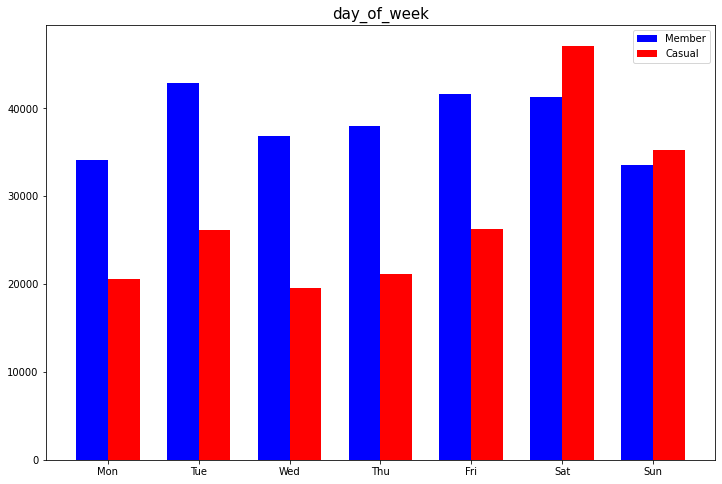

In [82]:
compare_cols(final_df, 'day_of_week', 'bar')

In [83]:
grouped_df = final_df.groupby("member_casual")

In [84]:
grouped_df[['Time_spent']].mean()/60 #get minutes

,Time_spent
member_casual,
casual,42.159542
member,14.204676


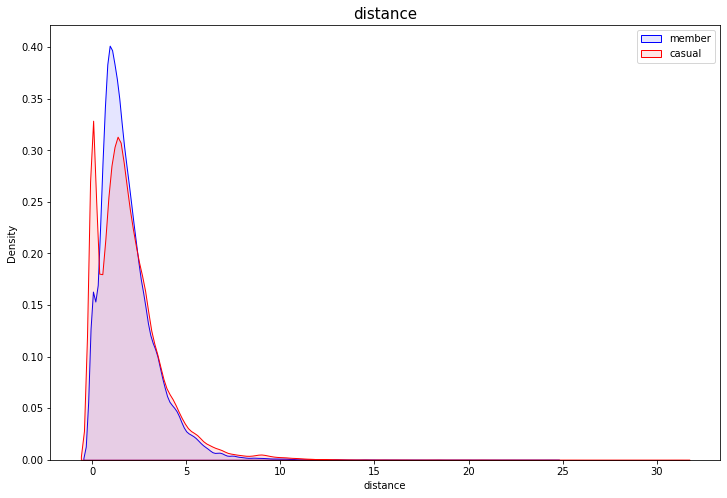

In [85]:
#example of relative frequency comparison

compare_cols(final_df, 'distance', 'de', True)

In [86]:
#example of absolute value comparison
# speed was removed
# compare_cols(final_df[final_df.Speed!=0], 'Speed', 'de', True)

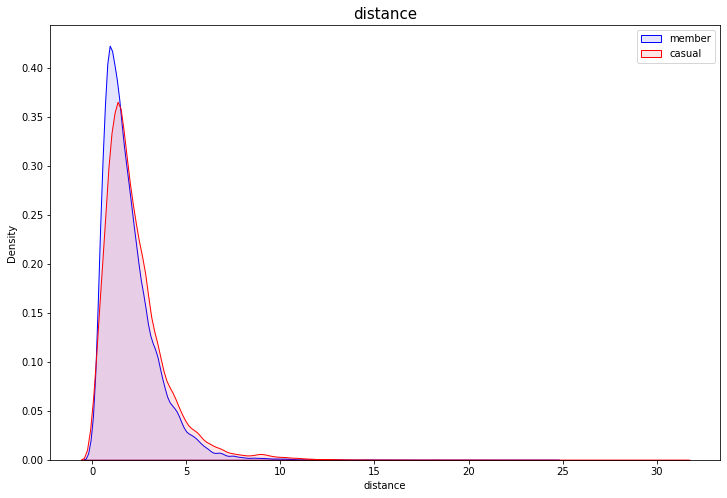

In [87]:
compare_cols(final_df[final_df.distance!=0], 'distance', 'density', False)

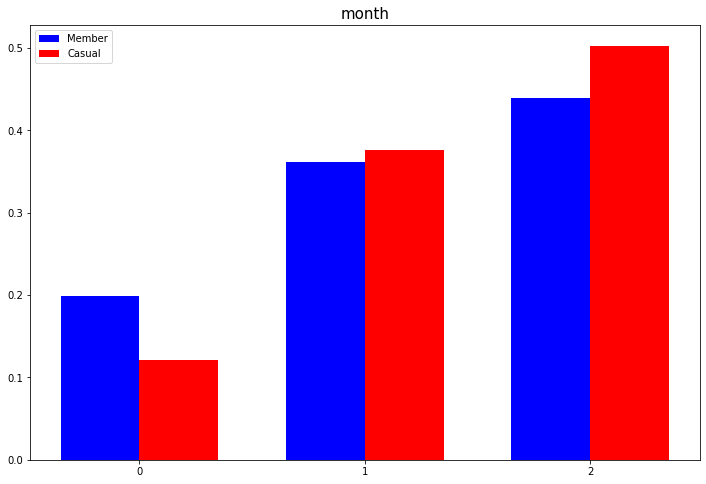

In [88]:
compare_cols(final_df, 'month', 'bar', True)

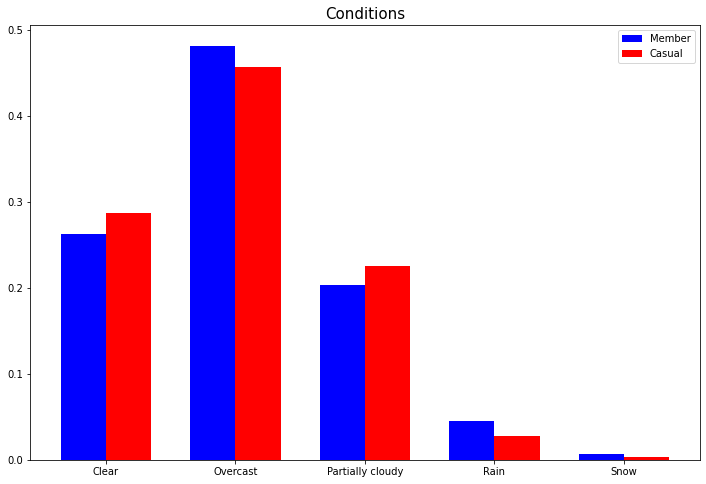

In [89]:
compare_cols(final_df, 'Conditions', 'bar', True)

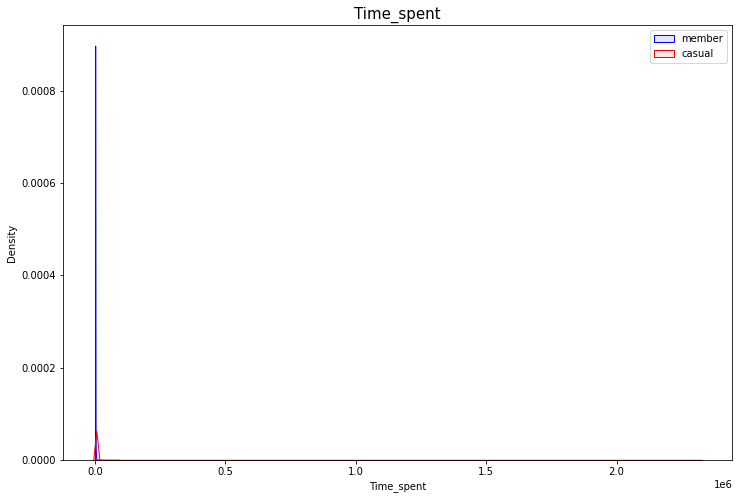

In [90]:
# too many outliers, impossible to visualize
compare_cols(final_df, 'Time_spent', 'density', False)

# Feature Engineering II <a class="anchor" id="chapter5"></a>

## Categorization for type Consistency <a class="anchor" id="section5_1"></a>

Some columns are regarded as numeric when they are categorical, here they are transformed for consistency. 

In [91]:
final_df.columns

Index(['index', 'rideable_type', 'started_at', 'ended_at', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

In [92]:
final_df.dtypes

index                           object
rideable_type                 category
started_at              datetime64[ns]
ended_at                datetime64[ns]
start_lat                       object
start_lng                       object
end_lat                         object
end_lng                         object
member_casual                 category
Maximum Temperature             object
Minimum Temperature             object
Temperature                     object
Precipitation                   object
Snow                            object
Snow Depth                      object
Wind Speed                      object
Wind Direction                  object
Visibility                      object
Cloud Cover                     object
Relative Humidity               object
Conditions                    category
Date                            object
month                            int64
distance                        object
Time_spent                     float64
month_day                

In [93]:
# some columns are categories but are counted as numeric
final_df._get_numeric_data().columns

Index(['month', 'Time_spent', 'month_day', 'hour_started', 'minute_started',
       'hour_ended', 'minute_ended', 'day_of_week', 'rideable_type_dummy',
       'Conditions_dummy', 'member_casual_dummy', 'hour_started_polar',
       'minute_started_polar', 'hour_ended_polar', 'minute_ended_polar'],
      dtype='object')

In [94]:
def make_categorical(df : pd.DataFrame, cols_to_categorize : list) -> pd.DataFrame:
  '''
  Make a set of columns categorical. 
  :df: dataframe to work on
  :cols_to_categorize: list of strings with the columns to make categorical
  :return: new dataframe
  '''
  df_ret = df.copy(deep = True)
  df_ret[cols_to_categorize] = df_ret[cols_to_categorize].astype('category')
  return df_ret

In [95]:
final_df.columns

Index(['index', 'rideable_type', 'started_at', 'ended_at', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

In [96]:
cols_to_categorize = ['day_of_week', 'rideable_type_dummy',
       'Conditions_dummy']
df_categorized = make_categorical(final_df, cols_to_categorize = cols_to_categorize)
df_categorized.dtypes

index                           object
rideable_type                 category
started_at              datetime64[ns]
ended_at                datetime64[ns]
start_lat                       object
start_lng                       object
end_lat                         object
end_lng                         object
member_casual                 category
Maximum Temperature             object
Minimum Temperature             object
Temperature                     object
Precipitation                   object
Snow                            object
Snow Depth                      object
Wind Speed                      object
Wind Direction                  object
Visibility                      object
Cloud Cover                     object
Relative Humidity               object
Conditions                    category
Date                            object
month                            int64
distance                        object
Time_spent                     float64
month_day                

In [97]:
final_df = df_categorized

In [98]:
final_df._get_numeric_data().columns

Index(['month', 'Time_spent', 'month_day', 'hour_started', 'minute_started',
       'hour_ended', 'minute_ended', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

The dataset is almost clustering ready. Just a few processing steps are left

## Time_spent Winsorization & drops <a class="anchor" id="section5_2"></a>

In [99]:
df = final_df.copy(deep = True)

Time spent is also featured with a high number of outliers. This could impact the analysis, as clustering is distance dependent. Here we propose a solution. 
A plot below, also presentjustifies the chapter. 

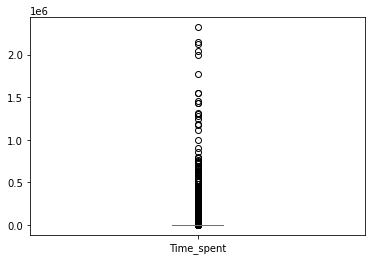

In [100]:
df['Time_spent'].plot.box()

From the company website: <br>
*Please know that bikes that are missing for longer than 24 hours can result in a $1,200 fee (plus tax) charged to the account holder that took out the bike.*

In [101]:
# result in hours is way higher than maximum number of hours of rental. After 24hrs
# a bike is considered missing. We will consider rides up to 48 hrs (day pass + missing)
# just to avoid losing too much
df['Time_spent'].max() / (3600)

644.5791666666667

In [102]:
# time spent is full of outliers as we saw at the beginning
# let's winsorize them as an option and see what happens
# we use the same function as the first notebook (here copied for simplicity as it would have been the only import).
def quantiles_and_iqr(col : pd.Series) -> tuple:
  """
  Function to return all canonical quantiles, the iqr and the bounds for outliers
  :col: Pandas series to examinate
  :return: tuple with (first_quantile, median, third_quantile, IQR, lower_buond, upper_bound)
  """
  q1 = col.quantile(0.25)
  med = col.quantile(0.5)
  q3 = col.quantile(0.75)
  iqr = q3 - q1
  lower_bound = (q1 - 1.5 * iqr)
  upper_bound = (q3 + 1.5 * iqr)
  return q1, med, q3, iqr, lower_bound, upper_bound

In [103]:
def clean_and_winsorize_df_col(df : pd.DataFrame, col_name : str, verbose = False, clean = True) -> pd.DataFrame:
  '''
  Applies winsorization to a given column and cleans it for rides longer than 48 hours
  if needed
  :df: Dataframe
  :col: column name
  :clean: if True removes rides that are longer than 48hrs in Time_spent
  :return: new dataframe
  '''
  col = df[col_name].copy(deep = True)
  if clean:
    #drop greater than 24 hours in seconds
    mask_drop = col > 24 * 3600
    print('Number of observations dropped:', mask_drop.sum())
    df.drop(df[mask_drop].index, inplace = True)
  _, _, _, _, lower_bound, upper_bound = quantiles_and_iqr(col)
  mask_lower = col < lower_bound
  mask_upper = col > upper_bound
  col[mask_lower] = lower_bound
  col[mask_upper] = upper_bound
  if verbose == True:
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    fig.suptitle('Before and After')
    df[col_name].plot(ax = axes[0], kind = 'density')
    # col.plot(ax = axes[1], kind = 'density')
    col.plot(ax = axes[1], kind = 'density')
  df[col_name] = col
  df.reset_index(inplace = True)

  return df


In [104]:
# in this cell we will either apply or not the transformation
# it all depends on two set parameters that can be commented out
winsor = False
verbose = False
clean = False
# comment out these two for a different behavior
winsor = True
verbose = False
clean = True
if winsor:
  df = clean_and_winsorize_df_col(df, 'Time_spent', verbose = verbose, clean = clean)

Number of observations dropped: 403


In [105]:
df.isna().sum()

level_0                 0
index                   0
rideable_type           0
started_at              0
ended_at                0
start_lat               0
start_lng               0
end_lat                 0
end_lng                 0
member_casual           0
Maximum Temperature     0
Minimum Temperature     0
Temperature             0
Precipitation           0
Snow                    0
Snow Depth              0
Wind Speed              0
Wind Direction          0
Visibility              0
Cloud Cover             0
Relative Humidity       0
Conditions              0
Date                    0
month                   0
distance                0
Time_spent              0
month_day               0
hour_started            0
minute_started          0
hour_ended              0
minute_ended            0
day_of_week             0
rideable_type_dummy     0
Conditions_dummy        0
member_casual_dummy     0
hour_started_polar      0
minute_started_polar    0
hour_ended_polar        0
minute_ended

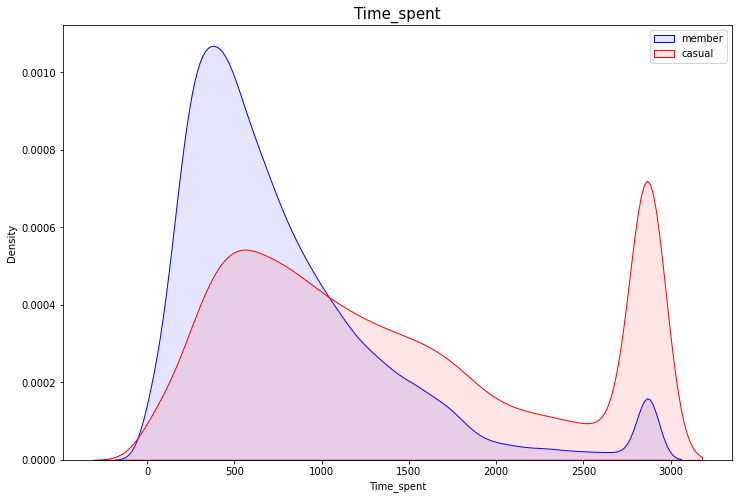

In [106]:
# now simple col comparison is nicer and easier to visualize
compare_cols(df, 'Time_spent', 'density', False)

# K-means clustering <a class="anchor" id="chapter6"></a>

The idea is that we wish to compute a clustering based on a subset of columns that we wish to analyze. Having obtained the clusters, we then observe what differences can be noticed between the clusters in terms of other variables that were not included in the process of forming them. With this in mind, we will build our hypothesis and design some tests on the information. Given that Kmean is not suitable for categorical variables, we attempt to cluster on continuous values and then analyze the categories' differences between the results. 

As a number of clusters, since we do not want to restrict ourselves too much and at the same time we do not want to identify a partition with too many clusters, we will attempt to find the optimal number of centroids of short size. 
We also will transform the categories, now considered as integers, to make the analysis more accurate. 


In [107]:
# older version
# cols_to_use = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'Temperature', 'Precipitation', 'Snow',
   #    'Wind Speed', 'Cloud Cover', 'Relative Humidity', 'distance', 'Time_spent', 'day_of_week', 
    #    'month_day', 'month', 'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
     #   'hour_started', 'minute_started', 'hour_ended', 'minute_ended', 'hour_started_polar',
      # 'minute_started_polar', 'hour_ended_polar', 'minute_ended_polar', 'group']

In [108]:
df.columns

Index(['level_0', 'index', 'rideable_type', 'started_at', 'ended_at',
       'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar'],
      dtype='object')

We wish to make a simple comparison. Clustering is not advised for categorical variables, so we will cluster on continuous relevant variables only, and then observe the differences across clusters of categorical variables. What follows is an hypothesis of what we could use

In [109]:
# newer version
cols_to_use = ['Temperature', # good indicator
       'Precipitation',       # bad indicator
       'distance',            # interesting indicator
       'Time_spent',          # interesting indicator
       'hour_started_polar',  # interesting indicator
       'hour_ended_polar',
          # same
       'Cloud Cover']



We ignored the other columns as we believe that those are good summarizing features for the missing ones. 

In [110]:
# imports
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [111]:
# we standardize the target features and overwrite them in the new df which will 
# be denoted as _scaled
std = StandardScaler()
std.fit(df[cols_to_use])
df_scaled = df.copy()
# df_scaled[cols_to_use] = pd.DataFrame(std.transform(df[cols_to_use]), columns=cols_to_use)

In [112]:
df_scaled[cols_to_use] = pd.DataFrame(std.transform(df[cols_to_use]), columns=cols_to_use)

In [113]:
# older version
#cols_cluster = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'distance', 'Time_spent', 'day_of_week', 
   #     'month_day', 'month', 'rideable_type_dummy','member_casual_dummy', 'hour_started_polar',
   #    'minute_started_polar', 'hour_ended_polar', 'minute_ended_polar', 'group' , 
   #     'Temperature', 'Precipitation', 'Snow', 'Wind Speed', 'Cloud Cover', 'Relative Humidity']

In [114]:
# newer version
cols_cluster = cols_to_use

In [115]:
df_scaled.shape == df.shape

True

In [116]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(df_scaled[cols_cluster])

KMeans(n_clusters=3)

In [117]:
df_scaled['labels'] = kmeans.labels_
df['labels'] = kmeans.labels_
# not needed as it is alwas the same value
# df_scaled['centroids'] = kmeans.cluster_centers_
# df['centroids'] = kmeans.cluster_centers_


In [118]:
df[cols_to_use].columns

Index(['Temperature', 'Precipitation', 'distance', 'Time_spent',
       'hour_started_polar', 'hour_ended_polar', 'Cloud Cover'],
      dtype='object')

In [119]:
# centroids coordinates in real data
std.inverse_transform(kmeans.cluster_centers_)[2]

array([ 1.24818543e+01,  4.75072925e-02,  1.44850453e+00,  6.27287340e+02,
       -7.09029879e-01, -6.99897039e-01,  6.13963250e+01])

In [120]:
def compare_groups(df, col_label, model, cols_cluster, col_to_compare, plot_type, centers = False, perc=None):
    
    plt.figure(figsize=(12,8))
    n_clusters = df[col_label].nunique()
    for i in range(n_clusters):
        if plot_type == 'scatter':
            col1 = col_to_compare[0]
            col2 = col_to_compare[1]
            scatter = plt.scatter(df.loc[df[col_label]==i, col1], df.loc[df[col_label]==i, col2], label= i, alpha=.1)
            if centers:
                ind1 = cols_cluster.index(col1)
                ind2 = cols_cluster.index(col2)
                plt.scatter(model.cluster_centers_[i,ind1], model.cluster_centers_[i,ind2], label=f'center {i}', s=2)
        if plot_type=='bar':
            index = np.arange(df[col_to_compare].nunique())
            bar_width = .8 / n_clusters
            vals = df[df[col_label]==i][col_to_compare].value_counts(sort=False)
            if perc == 'within':
                vals = vals / df[col_to_compare].value_counts(sort=False)
            elif perc == 'across':
                    vals = vals / df[df[col_label]==i][col_to_compare].shape[0]
                    
            plt.bar(index+bar_width*i, vals, bar_width, label=i)
            if col_to_compare=='day_of_week':       
                xlabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
            elif df[col_to_compare].dtype.name=='category':
                xlabels = df[col_to_compare].value_counts(sort=False).index
            elif col_to_compare == 'month':
                xlabels = ['Feb', 'Mar', 'Apr']
            else:
                xlabels = index
            if i == n_clusters-1:
                plt.xticks(index+bar_width*i/2, xlabels)

        elif 'de' in plot_type:
            sns.kdeplot(df.loc[df[col_label]==i, col_to_compare], alpha=.1, label=i, fill=True, bw_adjust=2)
            
        elif plot_type == 'hist':
            vals = df[df[col_label]==i][col_to_compare]
            bins = 50
            plt.hist(vals, label=i, bins = bins, alpha = 0.5)

    if col_to_compare == 'Precipitation' or col_to_compare == 'Snow': #add this because otherwise cannot see anything
      plt.xlim([-0.5,2])

    plt.title(col_to_compare, size=15)
    plt.legend()
    plt.show()




In [121]:
df.labels.value_counts()

2    209319
1    144008
0    110594
Name: labels, dtype: int64

In [122]:
df.columns

Index(['level_0', 'index', 'rideable_type', 'started_at', 'ended_at',
       'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar', 'labels'],
      dtype='object')

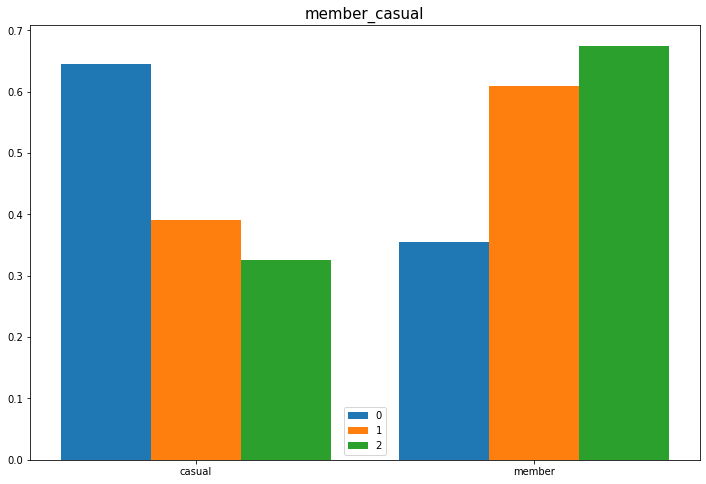

In [123]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'member_casual', 'bar', perc = 'across')

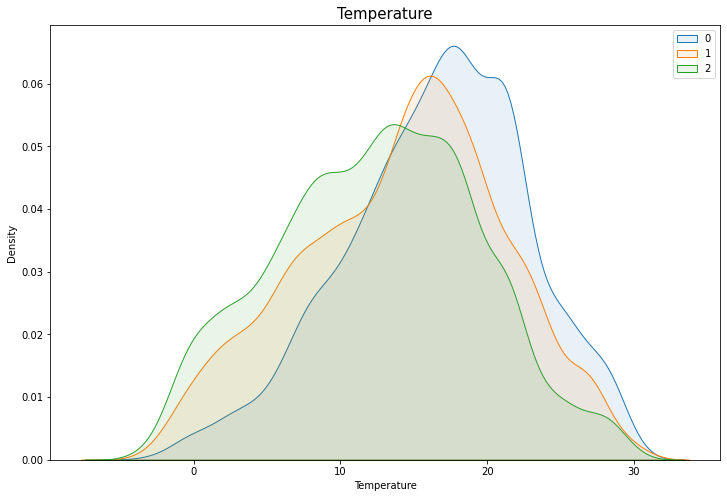

In [124]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'Temperature', 'de', perc = 'across')

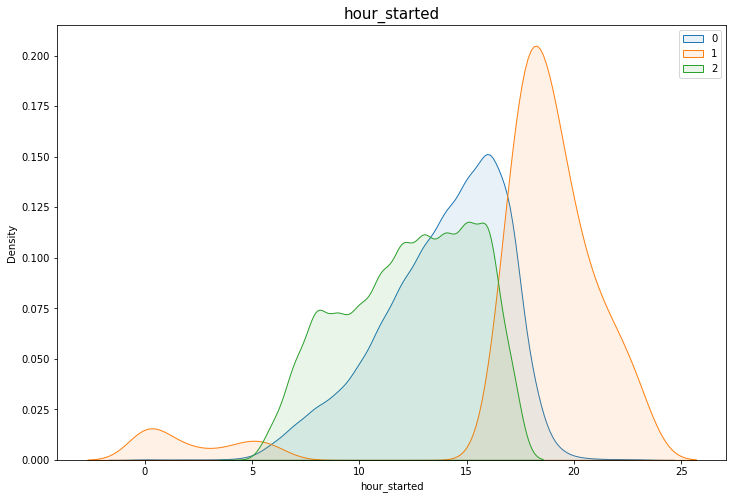

In [125]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'hour_started', 'de', perc = 'within')

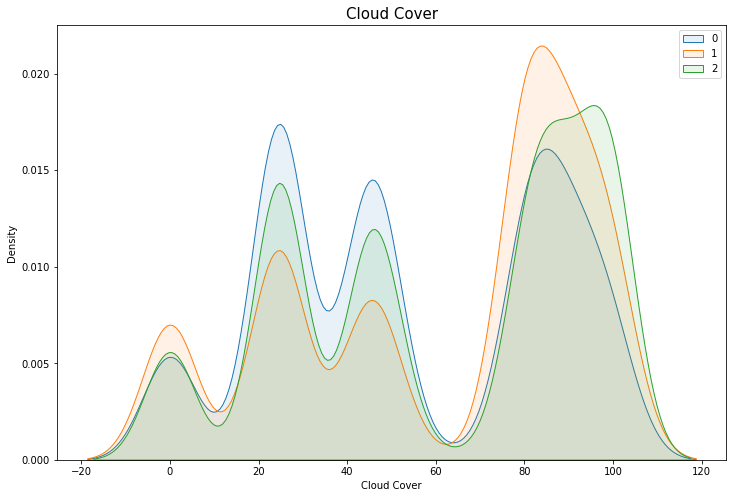

In [126]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'Cloud Cover', 'de', perc = 'across')

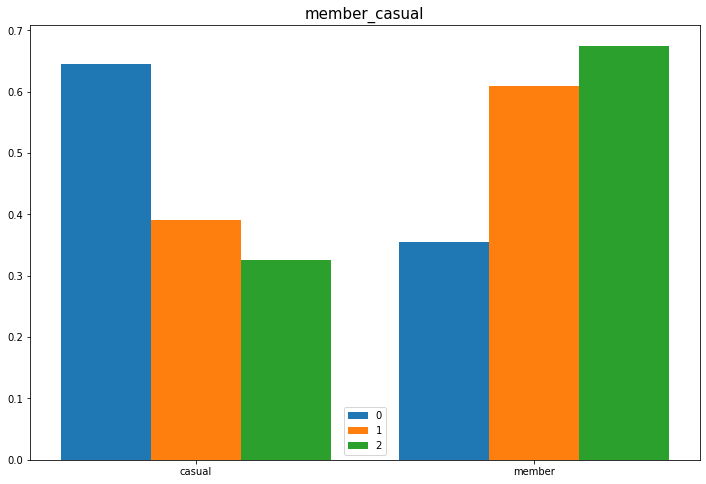

In [127]:
# blue is member, green is leisure
compare_groups(df,'labels', kmeans,  cols_cluster, 'member_casual', 'bar', perc = 'across')

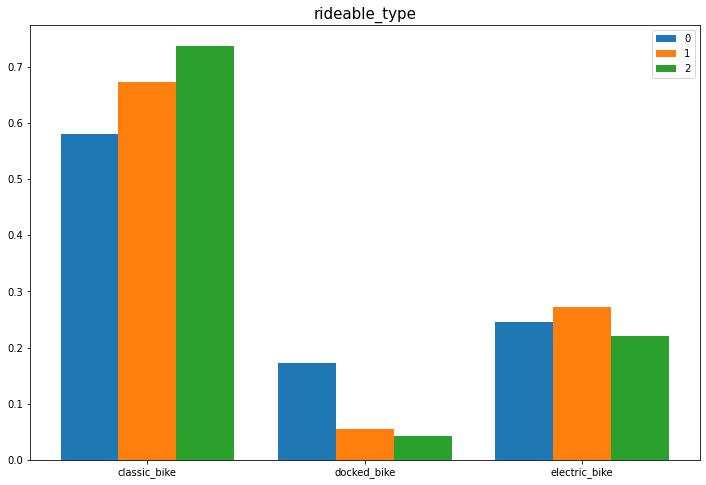

In [128]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'rideable_type', 'bar', perc = 'across')

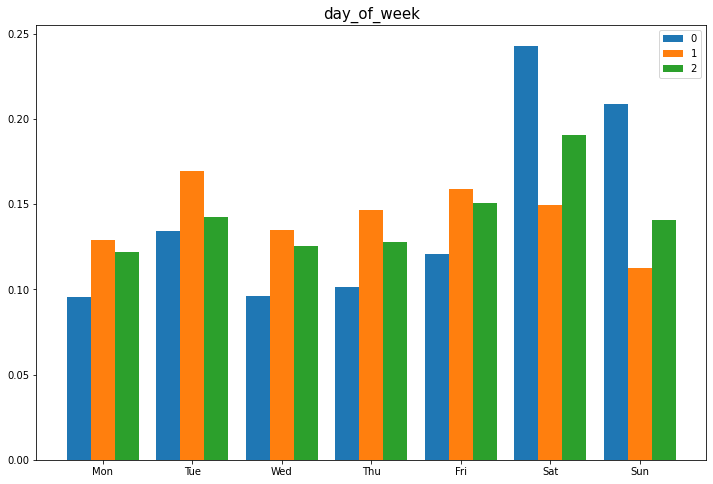

In [129]:
# green are leasure users, blue are work users. may plots show this and this is the last
# proof, in this case we note that across time most of the green users concentrate on the weekends. 
# instead, blue tends to be more constant
compare_groups(df,'labels', kmeans,  cols_cluster, 'day_of_week', 'bar', perc = 'across')

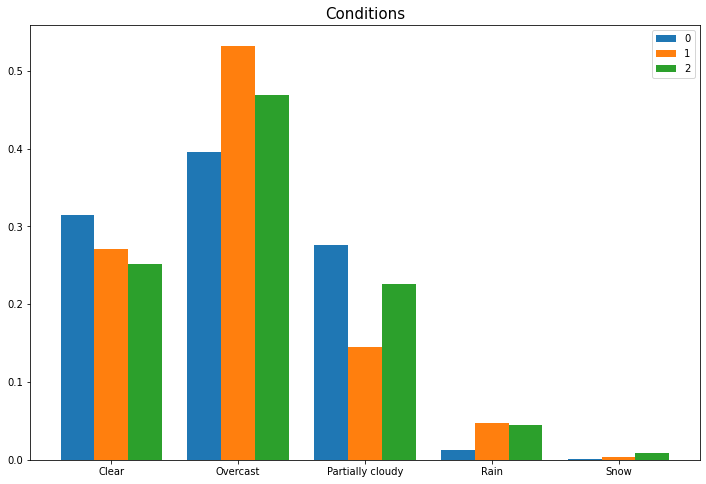

In [130]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'Conditions', 'bar', perc = 'across')

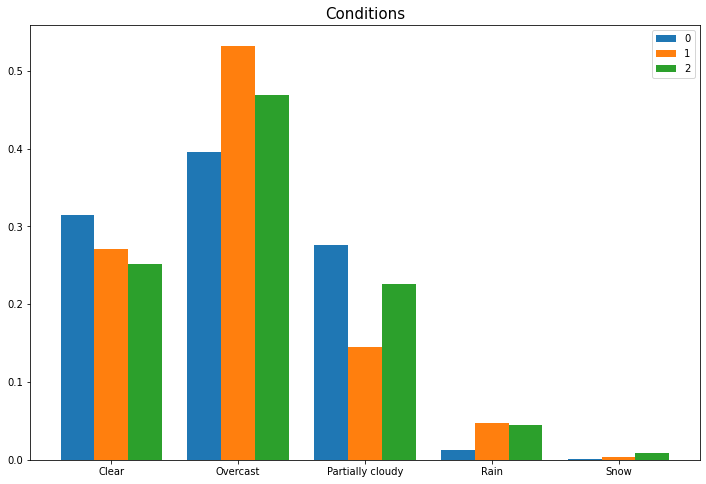

In [131]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'Conditions', 'bar', perc = 'across')

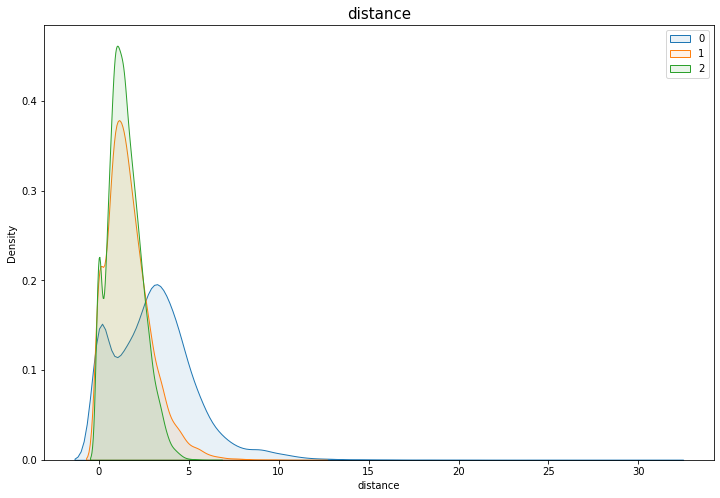

In [132]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'distance', 'de', perc = 'across')

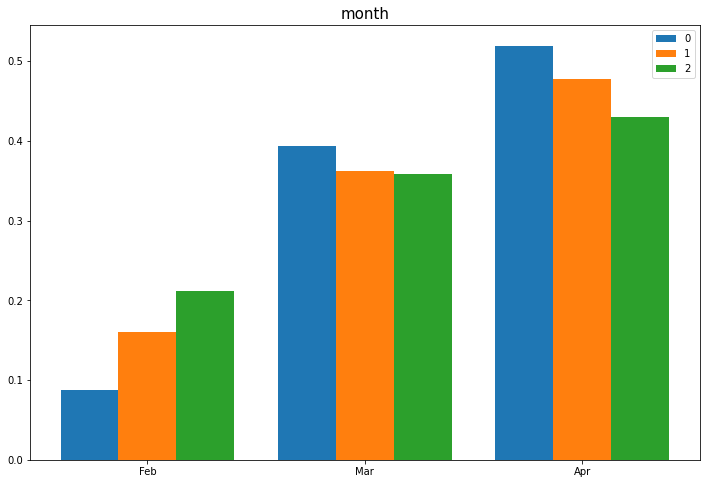

In [133]:
compare_groups(df,'labels', kmeans,  cols_cluster, 'month', 'bar', perc = 'across')

In [134]:
df.labels.value_counts()

2    209319
1    144008
0    110594
Name: labels, dtype: int64

In [135]:
def plot_kmean(dataset : pd.DataFrame, x_var : str, y_var : str, sample_size = 1000) -> None:
  '''
  Plots the result of a Kmeans algorithm in an R^2 space. Labels are colored differently
  to underline possible differences conditional on the coordinates in the classes.
  Obviously, the two have to be continuous. 
  : dataset: dataframe to work on. Must have already  undergone kmeans and standardization
  : x_var: string identifying variable for the x axis 
  : y_var: string identifying variable for the y axis
  : sample_size: size of the sample to plot, if the observations are too many
  '''
  fig, ax = plt.subplots(figsize=(15,8))
  k = np.int(dataset.labels.nunique())
  if (dataset[x_var].dtype.name == 'category' or dataset[y_var].dtype.name == 'category'):
    raise Exception('Cannot plot a categorical variable on the xy axis, please choose one that is considered to be an integer.')
  if (dataset[x_var].dtype.name == 'object' or dataset[y_var].dtype.name == 'object'):
      raise Exception('Cannot plot an object variable on the xy axis, please choose one that is considered to be an integer.')
  if sample_size != None:
    dataset = dataset.sample(n = sample_size)
  sns.scatterplot(x = x_var, y= y_var, data=dataset, 
                  palette=sns.color_palette("bright",k),
                  hue='labels', #size="centroids", size_order=[1,0],
                  legend="brief", ax=ax).set_title('Clustering')
    #th_centroids = model.cluster_centers_
    #ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [136]:
# this would return an error
# plot_kmean(df, 'member_casual', 'start_lat', sample_size = 1000)

In [137]:
df.columns

Index(['level_0', 'index', 'rideable_type', 'started_at', 'ended_at',
       'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual',
       'Maximum Temperature', 'Minimum Temperature', 'Temperature',
       'Precipitation', 'Snow', 'Snow Depth', 'Wind Speed', 'Wind Direction',
       'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions', 'Date',
       'month', 'distance', 'Time_spent', 'month_day', 'hour_started',
       'minute_started', 'hour_ended', 'minute_ended', 'day_of_week',
       'rideable_type_dummy', 'Conditions_dummy', 'member_casual_dummy',
       'hour_started_polar', 'minute_started_polar', 'hour_ended_polar',
       'minute_ended_polar', 'labels'],
      dtype='object')

# Saving the dataset <a class="anchor" id="chapter7"></a>

The information, now processed and ordered, will be saved in two distinct datasets to allow uploading into github. In later sections a merge of the two will take place. 

In [138]:
# older version
# df_saved = final_df.to_csv('/content/h_farm_group_work/final_df.csv')

In [139]:
# newer version
df_saved = final_df.to_csv('/content/h_farm_group_work/processed_df.csv')

In [140]:
# it is important to notice that google does not work well when downloading and
# writing data to a csv format. Also uploading has evident problems.
# Given that data is changed when transferred, we could not split the notebook
# in two.